# Minplus algebra experiment

This code attempts to learn the 2D mixture prior
$J(x) = min(\frac{1}{2\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 2

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 50

# Number of samples from the solution we have access to
data_points = 500

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# Example: Visualize the target convex and prior functions in 2D

Text(0, 0.5, 'prior_true($x_2$,0)')

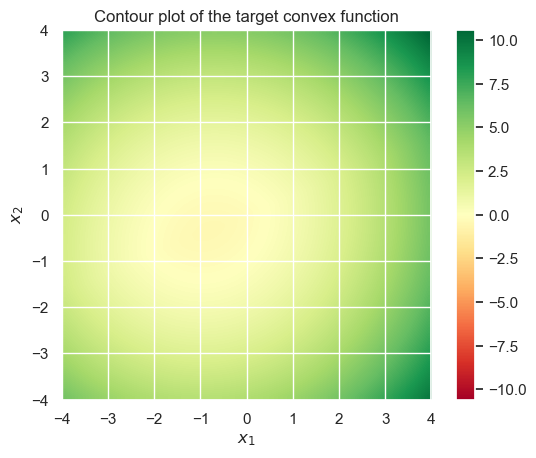

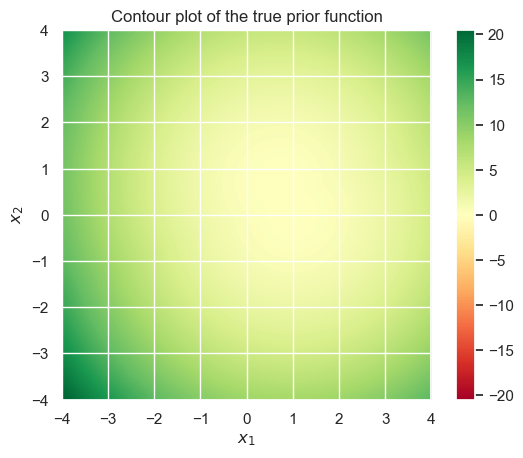

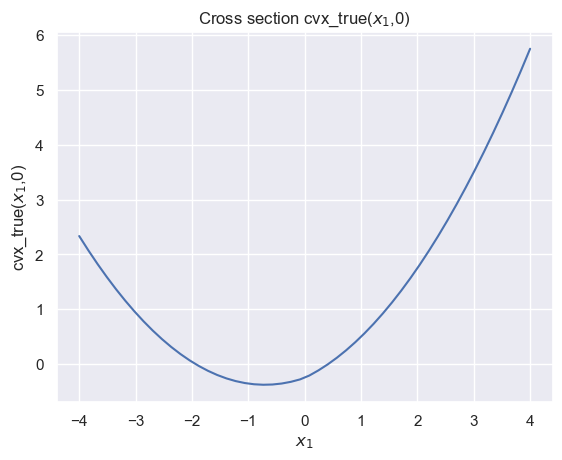

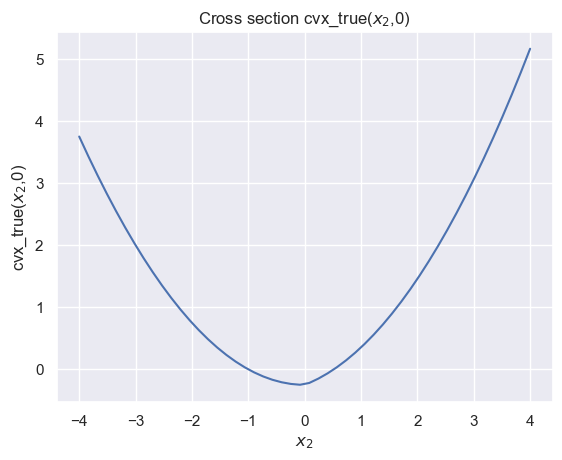

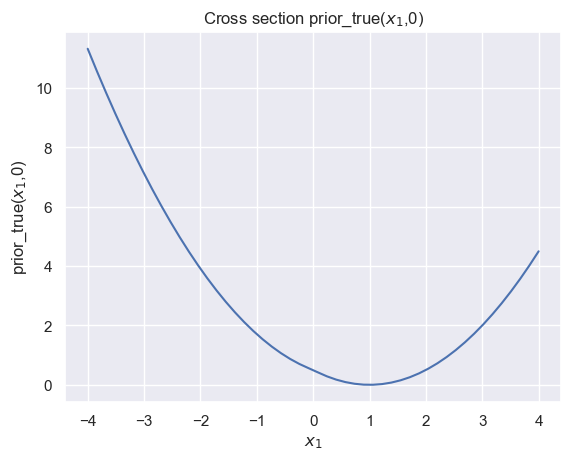

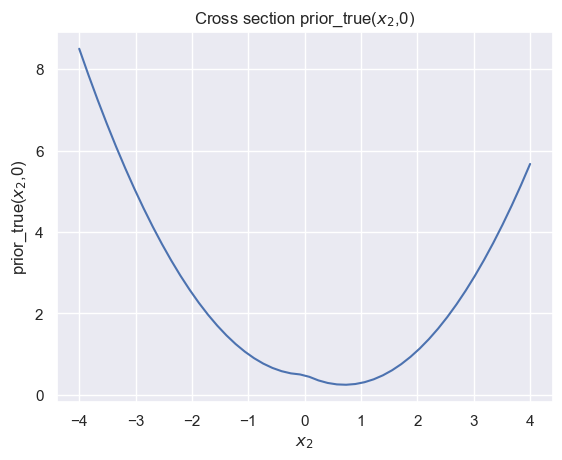

In [5]:
# Generate a square [-a, a]^{2} square meshgrid and recover the list of points
xi = np.linspace(-a,a,spacing)
mesh = np.meshgrid(xi, xi) 

# Recover the list of points as a matrix with 2 columns
pts = np.array(mesh).reshape(2, -1).T

# Evaluate the target convex and prior functions, then reshape them to fit the meshgrid
example_cvx_true = cvx_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
example_prior_true = prior_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

# Plot 2D contours cvx_true(x1,x2) = C
fig1, ax1 = plt.subplots()
im1 = ax1.imshow(example_cvx_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_cvx_true).max(), vmin=-abs(example_cvx_true).max())

plt.title('Contour plot of the target convex function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im1)

# Plot 2D contours prior_true(x1,x2) = C
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(example_prior_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_prior_true).max(), vmin=-abs(example_prior_true).max())

plt.title('Contour plot of the true prior function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im2)

# Plot the cross sections cvx_true(x1,0), cvx_true(0,x2), prior_true(x1,0) and prior_true(0,x2)
x1_0_points = np.array(np.meshgrid(xi, 0) ).reshape(2, -1).T
x2_0_points = np.array(np.meshgrid(0, xi) ).reshape(2, -1).T

x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

plt.subplots()
plt.plot(xi, x1_0_cvx_true.ravel(), "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('cvx_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_cvx_true.ravel(), "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('cvx_true($x_2$,0)')

plt.subplots()
plt.plot(xi, x1_0_prior_true.ravel(), "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('prior_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_prior_true.ravel(), "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('prior_true($x_2$,0)')

## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 9.995920181274414
iteration 0 loss 49.387657165527344
iteration 500 loss 0.2836509346961975
iteration 1000 loss 0.12124636769294739
iteration 1500 loss 0.09042011946439743
iteration 2000 loss 0.06344156712293625
iteration 2500 loss 0.04140453413128853
iteration 3000 loss 0.025745654478669167
iteration 3500 loss 0.01620689406991005
iteration 4000 loss 0.010780773125588894
iteration 4500 loss 0.007586670108139515
iteration 5000 loss 0.005579716060310602
iteration 5500 loss 0.004230715334415436
iteration 6000 loss 0.003323269309476018
iteration 6500 loss 0.002707769861444831
iteration 7000 loss 0.002259317087009549
iteration 7500 loss 0.0018953792750835419
iteration 8000 loss 0.0015845573507249355
iteration 8500 loss 0.0013131449231877923
iteration 9000 loss 0.0010763731552287936
iteration 9500 loss 0.0008739323238842189
iteration 10000 loss 0.0007058671908453107
iteration 10500 loss 0.0005699832108803093
iteration 11000 loss 0.000461116258520633
iteration 11500 loss 0.00

L2 loss -- Plot

loss -10.813824653625488
loss -58.76112365722656
loss -98.01071166992188
loss -131.24005126953125
loss -159.62677001953125
loss -183.7711181640625
loss -204.1467742919922
loss -221.17230224609375
loss -235.36624145507812
loss -247.40927124023438
loss -257.915771484375
loss -267.28314208984375
loss -275.7230529785156
loss -283.406494140625
loss -290.5442810058594
loss -297.35223388671875
loss -304.0174560546875
loss -310.6931457519531
loss -317.49560546875
loss -324.50006103515625
loss -331.7411193847656
loss -339.2197265625
loss -346.9146728515625
loss -354.7943115234375
loss -362.82391357421875
loss -370.97052001953125
loss -379.2060852050781
loss -387.5120544433594
loss -395.87567138671875
loss -404.28564453125
loss -412.732421875
loss -421.20892333984375
loss -429.7112121582031
loss -438.2367248535156
loss -446.7832946777344
loss -455.350341796875
loss -463.93701171875
loss -472.542236328125
loss -481.16552734375
loss -489.80657958984375
final mse:  0.213501438498497
max, min: 18.84

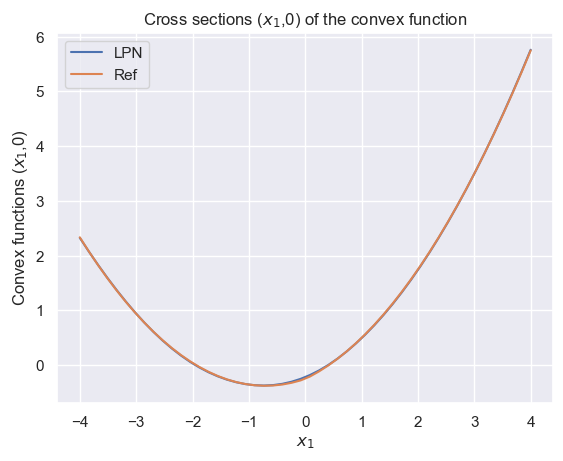

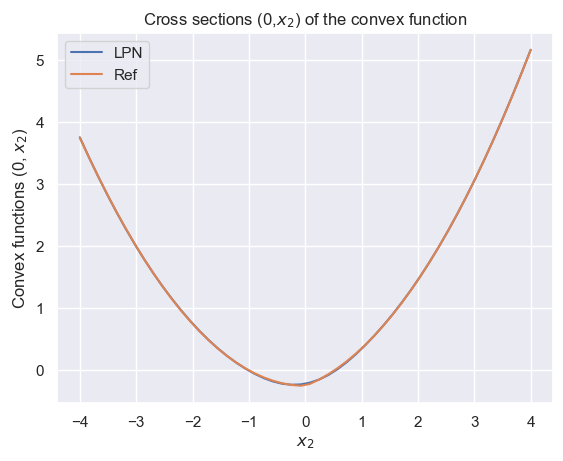

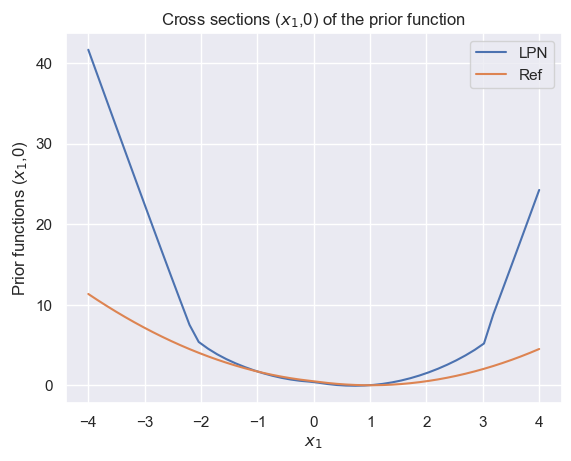

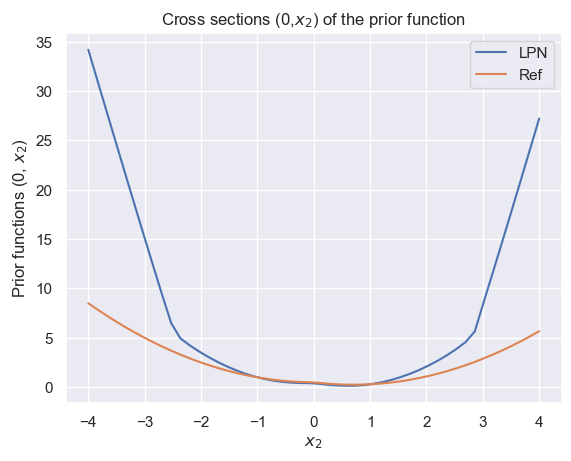

In [8]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

L1 loss -- Train

In [9]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 1

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(20000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

iteration 0 loss 3.4520952701568604
iteration 0 loss 5.767504692077637
iteration 500 loss 0.2393774688243866
iteration 1000 loss 0.1656257063150406
iteration 1500 loss 0.11281032115221024
iteration 2000 loss 0.05397586151957512
iteration 2500 loss 0.025503255426883698
iteration 3000 loss 0.015896108001470566
iteration 3500 loss 0.01300843246281147
iteration 4000 loss 0.011753515340387821
iteration 4500 loss 0.010770081542432308
iteration 5000 loss 0.010093744844198227
iteration 5500 loss 0.009503988549113274
iteration 6000 loss 0.009551693685352802
iteration 6500 loss 0.009017926640808582
iteration 7000 loss 0.009015582501888275
iteration 7500 loss 0.008758197538554668
iteration 8000 loss 0.008303342387080193
iteration 8500 loss 0.00822398066520691
iteration 9000 loss 0.007774358615279198
iteration 9500 loss 0.00762237748131156
iteration 10000 loss 0.008095744997262955
iteration 10500 loss 0.007351526524871588
iteration 11000 loss 0.007223334163427353
iteration 11500 loss 0.00722883502

L1 loss -- Plot

loss -10.24350357055664
loss -57.99662780761719
loss -97.36839294433594
loss -130.7227783203125
loss -159.1248321533203
loss -183.2481689453125
loss -203.6763153076172
loss -220.88116455078125
loss -235.20700073242188
loss -247.13250732421875
loss -257.2227783203125
loss -266.02984619140625
loss -274.06365966796875
loss -281.75927734375
loss -289.45758056640625
loss -297.4030456542969
loss -305.7464599609375
loss -314.5519714355469
loss -323.81475830078125
loss -333.48699951171875
loss -343.50244140625
loss -353.7928771972656
loss -364.29296875
loss -374.9482116699219
loss -385.7246398925781
loss -396.61083984375
loss -407.5877685546875
loss -418.62481689453125
loss -429.7013244628906
loss -440.80621337890625
loss -451.93231201171875
loss -463.0755615234375
loss -474.23272705078125
loss -485.40093994140625
loss -496.5778503417969
loss -507.76220703125
loss -518.953125
loss -530.1509399414062
loss -541.355224609375
loss -552.564453125
final mse:  0.31456196308135986
max, min: 19.037714 

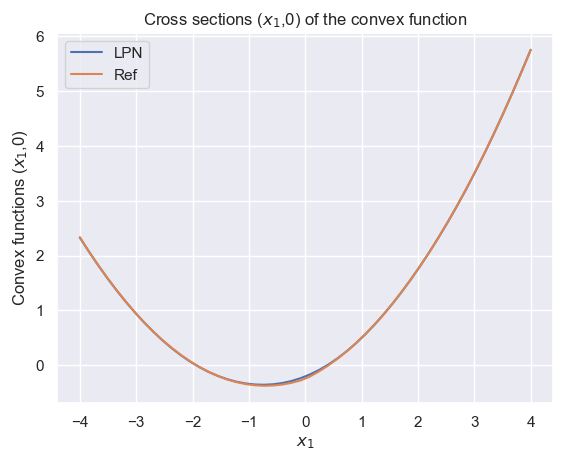

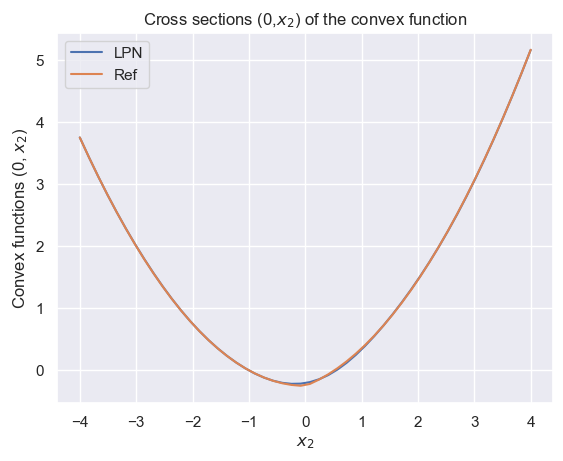

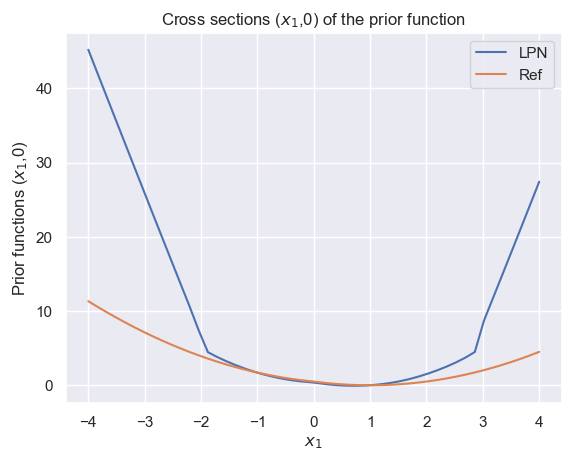

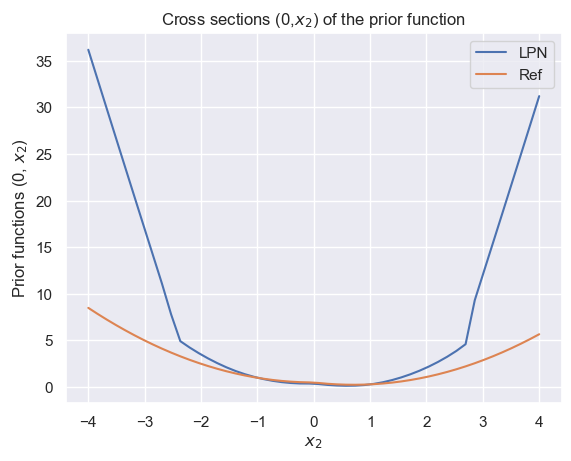

In [10]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [11]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [12]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [13]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [14]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [15]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [16]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)